In [1]:
%matplotlib inline
import quest
import numpy as np 
from matplotlib import colors, cm, pyplot as plt
from gazar import grid

In [2]:
VICKSBURG = 'Vicksburg'
PROVO = 'Provo'

location = PROVO
# location = VICKSBURG

SERVICE_FEATURES = {VICKSBURG: 'svc://usgs-ned:13-arc-second/581d213be4b08da350d52d69', #581d213be4b08da350d52d67',
                    PROVO: 'svc://usgs-ned:13-arc-second/581d2162e4b08da350d5325e'
                    }
BBOXES = {VICKSBURG: [-90.9, -90.8, 32.2, 32.3],
          PROVO: [-111.6, -111.4, 40.0, 40.15]
         }

OUTLETS = {VICKSBURG: (-90.889, 32.2133),
           PROVO: (-111.44851851851851, 40.0787962962963),
          }

service_feature = SERVICE_FEATURES[location]
bbox = BBOXES[location]
outlet = OUTLETS[location]

In [3]:
# create new collection
# (deletes existing collection if it exists)
try:
    quest.api.new_collection('test')
except ValueError:
    quest.api.delete('test')
    quest.api.new_collection('test')

In [4]:
# download elevation data
feature = quest.api.add_features('test', service_feature)
dataset = quest.api.stage_for_download(feature)
quest.api.download_datasets(dataset)

... ... .img format raster saved at /Users/rditlsc9/Library/Application Support/quest/projects/default/test/d0d6d62f519c43568b250c5707d00691.img


{'dabaa2111eea488f9cba5034ba8892d0': 'downloaded'}

In [5]:
# merge and clip tiles
result = quest.api.apply_filter('raster-merge', datasets=dataset, options={'bbox': bbox})
elevation = result['datasets'][0]

In [6]:
# run pit filling algorithm
algorithm = 'go-fill'  # one of ['flats', 'go-fill', 'go-breach']
result = quest.api.apply_filter('raster-fill', datasets=elevation, options={'algorithm': algorithm})
elevation = result['datasets'][0]

Setting up go-spatial tool: FillDepressions
Running process...
Done!


In [7]:
# run flow accumulation
algorithm = 'go-d8'  # one of ['d8', 'go-d8', 'go-fd8']
result = quest.api.apply_filter('raster-flow-accumulation', datasets=elevation, options={'algorithm': algorithm})
flow_accumulation_dataset_id = result['datasets'][0]

Setting up go-spatial tool: D8FlowAccumulation
Running process...
Done!


In [8]:
# experimental function for snapping outlet point river pixel
#NOTE: this function is dependent on the flow accumulation results that don't seem reasonable
def snap_points(flow_accumulation, points, search_radius=100):
    max_points = []
    for x, y in points:
        raster = flow_accumulation[x-search_radius:x+search_radius, y-search_radius:y+search_radius]
        xmax, ymax = np.unravel_index(raster.argmax(), raster.shape)
        max_points.append((int(x-search_radius+xmax), int(y-search_radius+ymax)))

    return max_points

In [9]:
# read in flow accumulation
flow_accumulation_dataset_file = quest.api.get_metadata(flow_accumulation_dataset_id) \
                                    [flow_accumulation_dataset_id]['file_path']
flow_accumulation_dataset = grid.GDALGrid(flow_accumulation_dataset_file)
flow_accumulation_data = flow_accumulation_dataset.np_array()

max_accumulation = flow_accumulation_data.max()
stream_threshold = max_accumulation * 0.01
rivers = np.ma.masked_where(flow_accumulation_data < stream_threshold, flow_accumulation_data)

max_index = np.unravel_index(flow_accumulation_data.argmax(), flow_accumulation_data.shape)
outlet_row = int(max_index[0])
outlet_col = int(max_index[1])
print('Max accumulation is {0} at {1} (orange dot)'.format(max_accumulation, (outlet_row, outlet_col)))
# NOTE: accumulation results don't seem reasonable

# find outlet pixel
outlet_col, outlet_row = flow_accumulation_dataset.lonlat2pixel(*outlet)
# outlet_col, outlet_row = snap_points(flow_accumulation_data, [(outlet_col, outlet_row)])[0]
print('Outlet accumulation is {0} at {1} (red dot)'.format(
    flow_accumulation_data[outlet_row, outlet_col], (outlet_row, outlet_col)))
outlet_lon, outlet_lat = flow_accumulation_dataset.pixel2lonlat(outlet_col, outlet_row)
print(outlet_lon, outlet_lat)
outlets = [(outlet_row, outlet_col)]

# read in elevation data
dem_file = quest.api.get_metadata(elevation)[elevation]['file_path']
dem = grid.GDALGrid(dem_file)
lat, lon = dem.latlon

Max accumulation is 171749.0 at (769, 1636) (orange dot)
Outlet accumulation is 171749.0 at (769, 1636) (red dot)
-111.44851851851851 40.0787962962963


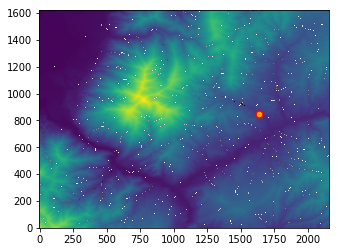

In [10]:
# plot outlet pixel with elevation and flow accumulation
fig, ax = plt.subplots()
ax.imshow(np.flip(dem.np_array(), 0))
plt.imshow(np.flip(rivers, 0), cmap=cm.gray_r, norm=colors.LogNorm(), origin="lower")

ax.scatter(x=outlet_col, y=rivers.shape[0] - outlet_row, s=50, color='red')
ax.scatter(x=max_index[1], y=rivers.shape[0] - max_index[0], s=20, color='orange')


0.001890711817937191


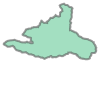

In [11]:
# run watershed delineation and extract shapely geometry
result = quest.api.apply_filter('raster-watershed-delineation', datasets=elevation, 
                       options={'outlet_points': outlets})
feature = result['features'][0]
geometry = quest.api.get_metadata(feature)[feature]['geometry']
print(geometry.area)
geometry

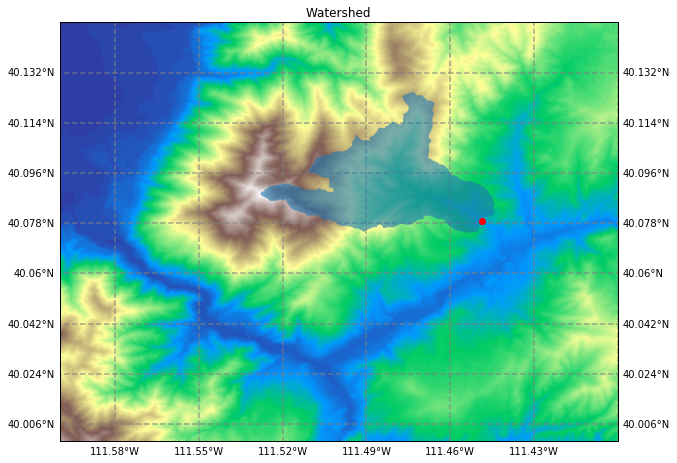

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

display_bbox = bbox
graticule_spacing = 0.01

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(display_bbox)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False

plt.contourf(lon, lat, dem.np_array(), 100, zorder=2, cmap=cm.terrain, transform=ccrs.PlateCarree())
ax.imshow(rivers, cmap=cm.ocean, origin='lower', zorder=3)
watershed = cfeature.ShapelyFeature([geometry], ccrs.PlateCarree())
ax.add_feature(watershed, zorder=4, alpha=0.6)
ax.scatter(x=outlet_lon, y=outlet_lat, color='red', zorder=5, transform=ccrs.PlateCarree())
plt.title("Watershed")
plt.show()